In [46]:
#FUNCTIONS TAKEN FROM LECTURE NOTES TO BUILD UPON
import math

class MinHeap:
    def __init__(self, data):
        self.items = data
        self.length = len(data)
        self.build_heap()
        self.map = {}
        for i in range(self.length):
            self.map[self.items[i].value] = i

    def find_left_index(self,index):
        return 2 * (index + 1) - 1

    def find_right_index(self,index):
        return 2 * (index + 1)

    def find_parent_index(self,index):
        return (index + 1) // 2 - 1  

    def sink_down(self, index):
        smallest_known_index = index
        left_index = self.find_left_index(index)
        right_index = self.find_right_index(index)
        if left_index < self.length and self.items[left_index].key < self.items[smallest_known_index].key:
            smallest_known_index = left_index

        if right_index < self.length and self.items[right_index].key < self.items[smallest_known_index].key:
            smallest_known_index = right_index

        if smallest_known_index != index:
            self.items[index], self.items[smallest_known_index] = self.items[smallest_known_index], self.items[index]
            
            self.map[self.items[index].value] = index
            self.map[self.items[smallest_known_index].value] = smallest_known_index

            self.sink_down(smallest_known_index)

    def build_heap(self):
        for i in range(self.length // 2 - 1, -1, -1):
            self.sink_down(i) 

    def insert(self, node):
        self.items.append(node)
        self.map[node.value] = self.length
        self.length += 1
        self.swim_up(self.length - 1)

    def swim_up(self, index):
        while index > 0 and self.items[index].key < self.items[self.find_parent_index(index)].key:
            parent_index = self.find_parent_index(index)
            self.items[index], self.items[parent_index] = self.items[parent_index], self.items[index]
            #update map
            self.map[self.items[index].value] = index
            self.map[self.items[parent_index].value] = parent_index
            index = parent_index

    def extract_min(self):
        if self.length == 0:
            return None
        self.items[0], self.items[self.length - 1] = self.items[self.length - 1], self.items[0]
        self.map[self.items[self.length - 1].value] = self.length - 1
        self.map[self.items[0].value] = 0

        min_node = self.items.pop()
        self.length -= 1
        self.map.pop(min_node.value, None)
        if self.length > 0:
            self.sink_down(0)
        return min_node

    def decrease_key(self, value, new_key):
        if value in self.map and new_key < self.items[self.map[value]].key:
            index = self.map[value]
            self.items[index].key = new_key
            self.swim_up(index)

    def is_empty(self):
        return self.length == 0

class Item:
    def __init__(self, value, key):
        self.key = key
        self.value = value
    
    def __str__(self):
        return "(" + str(self.key) + "," + str(self.value) + ")"

class WeightedGraph:

    def __init__(self,nodes):
        self.graph=[]
        self.weights={}
        for node in range(nodes):
            self.graph.append([])

    def add_node(self,node):
        self.graph[node]=[]

    def add_edge(self, node1, node2, weight):
        if node2 not in self.graph[node1]:
            self.graph[node1].append(node2)
        self.weights[(node1, node2)] = weight

    def get_weights(self, node1, node2):
        if self.are_connected(node1, node2):
            return self.weights[(node1, node2)]

    def are_connected(self, node1, node2):
        for neighbour in self.graph[node1]:
            if neighbour == node2:
                return True
        return False

    def get_neighbors(self, node):
        return self.graph[node]

    def get_number_of_nodes(self,):
        return len(self.graph)
    
    def get_nodes(self,):
        return [i for i in range(len(self.graph))]


In [47]:
# PART 1.1
# DIJKSTRAS ALGORITHM

def dijkstra(graph, source, k):
    # Initializing distances and paths
    node_count = graph.get_number_of_nodes()
    distances = {node: float('inf') for node in range(node_count)}
    paths = {node: [] for node in range(node_count)}
    relaxation_count = {node: 0 for node in range(node_count)}
    
    # Setting distance and path for source
    distances[source] = 0
    paths[source] = [source]
    
    # Initializing MinHeap with infinity distances except for the source
    initialize_heap = [Item(node, distances[node]) for node in range(node_count)]
    min_heap = MinHeap(initialize_heap)
    
    # Dijkstra's algorithm with relaxation limit
    while not min_heap.is_empty():
        current_node = min_heap.extract_min()
        node_index = current_node.value
        
        # Stop if the node has been relaxed k times
        if relaxation_count[node_index] >= k:
            continue
        
        for neighbor in graph.get_neighbors(node_index):
            weight = graph.get_weights(node_index, neighbor)
            new_distance = distances[node_index] + weight
            
            # Relaxation condition
            if new_distance < distances[neighbor] and relaxation_count[neighbor] < k:
                distances[neighbor] = new_distance
                paths[neighbor] = paths[node_index] + [neighbor]
                min_heap.decrease_key(neighbor, new_distance)
                relaxation_count[neighbor] += 1
    
    return distances, paths

# Example Usage:
g = WeightedGraph(5)  # Graph with 5 nodes
g.add_edge(0, 1, 4)
g.add_edge(0, 2, 1)
g.add_edge(2, 1, 2)
g.add_edge(1, 3, 1)
g.add_edge(2, 3, 5)
g.add_edge(3, 4, 3)

distances, paths = dijkstra(g, 0, 2)  # Find shortest paths from node 0 with relaxation limit 2
print("Distances:", distances)
print("Paths:", paths)


Distances: {0: 0, 1: 3, 2: 1, 3: 6, 4: 9}
Paths: {0: [0], 1: [0, 2, 1], 2: [0, 2], 3: [0, 2, 3], 4: [0, 2, 3, 4]}


In [48]:
# PART 1.2
# BELLMAN FORD'S ALGRITHM

def BellmanFord(g,src,k):
    dist = {}
    path = {}
    dist2 = {}
    path2 = {}
    num_relax = {}
    
    #initializing distance of all nodes to infinity and dist of 1st node as 0
    for i in range(g.get_number_of_nodes()):
        dist[i] = float("inf")
        path[i] = [src]
        dist2[i] = float("inf")
        path2[i] = [src]
        num_relax[i] = 0
        
    dist[src] = 0
    dist2[src] = 0
    path[src] = [src]
    path2[src] = [src]
    
    for _ in range(len(g.get_nodes()) - 1):
        difference = False
        for node in g.get_nodes():
            for n in g.get_neighbors(node):
                weight = g.get_weights(node,n)
                if weight != None:
                    if dist[node] + weight < dist[n] and num_relax[node] < k:
                        dist[n] = dist[node] + weight
                        path[n] = path[node] + [n]
                        num_relax[n] += 1
                        difference = True
        if not difference:
            return dist,path

    

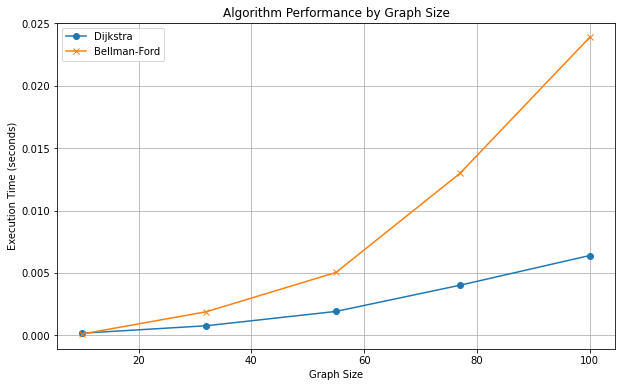

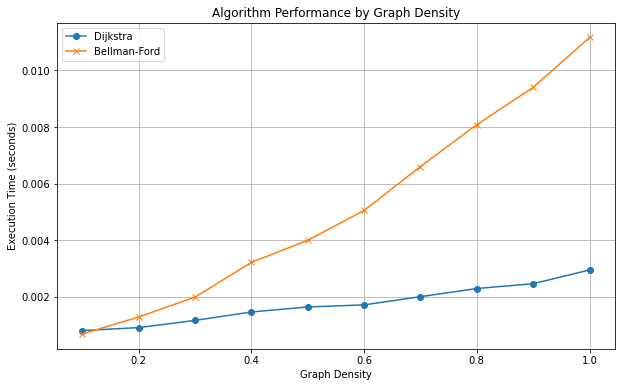

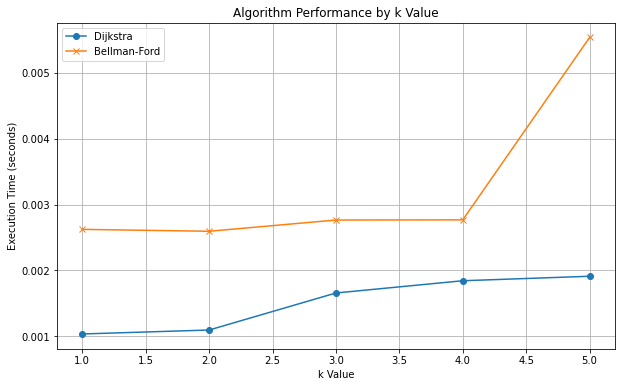

In [49]:
#PART 1.3
#EXPERIMENT TO ANALYZE PERFORMANCE

import matplotlib.pyplot as plt
import numpy as np
import time
import random

# function to generate a random graph based on size and density
def generate_random_graph(num_nodes: int, density: float) -> WeightedGraph:
    graph = WeightedGraph(num_nodes)
    for node in range(num_nodes):
        for target_node in range(node + 1, num_nodes):
            if random.random() < density:
                weight = random.randint(1, 10)
                graph.add_edge(node, target_node, weight)
                graph.add_edge(target_node, node, weight)  # Assuming undirected graph for simplicity
    return graph

# function to run the experiment and collect data
def run_experiment(graph_sizes: list[int], densities: list[float], k_values: list[int]) -> dict:
    results = {"Dijkstra": [], "BellmanFord": []}
    
    for size in graph_sizes:
        for density in densities:
            for k in k_values:
                graph = generate_random_graph(size, density)
                
                # Dijkstra
                start_time = time.time()
                dijkstra(graph, 0, k)
                dijkstra_time = time.time() - start_time
                
                # Bellman-Ford
                start_time = time.time()
                BellmanFord(graph, 0, k)
                bellman_ford_time = time.time() - start_time
                
                results["Dijkstra"].append((size, density, k, dijkstra_time))
                results["BellmanFord"].append((size, density, k, bellman_ford_time))
                
    return results

#graph size
sizes = np.linspace(10, 100, 5, dtype=int)  # Example: Graph sizes from 10 to 100
constant_density = 0.5  # Keeping density constant
constant_k = 3  # Keeping k constant

dijkstra_times_size = []
bellman_ford_times_size = []

for size in sizes:
    graph = generate_random_graph(size, constant_density)
    start_time = time.time()
    dijkstra(graph, 0, constant_k)
    dijkstra_times_size.append(time.time() - start_time)

    start_time = time.time()
    BellmanFord(graph, 0, constant_k)
    bellman_ford_times_size.append(time.time() - start_time)

# plotting
plt.figure(figsize=(10, 6))
plt.plot(sizes, dijkstra_times_size, label='Dijkstra', marker='o')
plt.plot(sizes, bellman_ford_times_size, label='Bellman-Ford', marker='x')
plt.xlabel('Graph Size')
plt.ylabel('Execution Time (seconds)')
plt.title('Algorithm Performance by Graph Size')
plt.legend()
plt.grid(True)
plt.show()

#graph density
constant_size = 50  # Keeping size constant for the density experiment
constant_k = 3  # Keeping k constant for the density experiment
densities = np.linspace(0.1, 1, 10)

dijkstra_times_density = []
bellman_ford_times_density = []

for density in densities:
    graph = generate_random_graph(constant_size, density)
    
    start_time = time.time()
    dijkstra(graph, 0, constant_k)
    dijkstra_times_density.append(time.time() - start_time)
    
    start_time = time.time()
    BellmanFord(graph, 0, constant_k)
    bellman_ford_times_density.append(time.time() - start_time)

# plotting 
plt.figure(figsize=(10, 6))
plt.plot(densities, dijkstra_times_density, label='Dijkstra', marker='o')
plt.plot(densities, bellman_ford_times_density, label='Bellman-Ford', marker='x')
plt.xlabel('Graph Density')
plt.ylabel('Execution Time (seconds)')
plt.title('Algorithm Performance by Graph Density')
plt.legend()
plt.grid(True)
plt.show()

# k values
constant_size = 50  # Keeping size constant for the k values experiment
constant_density = 0.5  # Keeping density constant for the k values experiment
k_values = list(range(1, 6))

dijkstra_times_k = []
bellman_ford_times_k = []

for k in k_values:
    graph = generate_random_graph(constant_size, constant_density)
    
    start_time = time.time()
    dijkstra(graph, 0, k)
    dijkstra_times_k.append(time.time() - start_time)
    
    start_time = time.time()
    BellmanFord(graph, 0, k)
    bellman_ford_times_k.append(time.time() - start_time)

# plotting
plt.figure(figsize=(10, 6))
plt.plot(k_values, dijkstra_times_k, label='Dijkstra', marker='o')
plt.plot(k_values, bellman_ford_times_k, label='Bellman-Ford', marker='x')
plt.xlabel('k Value')
plt.ylabel('Execution Time (seconds)')
plt.title('Algorithm Performance by k Value') 
plt.legend()
plt.grid(True)
plt.show()



In [50]:
#REFLECTIONS
'''

The above experiment compares the performance of the two algorithms on the basis of Graph Size, Graph Density and k values.

Graph 1: Performance by Graph Size

- Dijkstra's Algorithm: Its execution time increases with graph size, but at a slower rate. This is in accordance with the time complexity of Dijkstra's algorithm, which is O(V log V + E) given that priority queue is used, where V is the number of vertices and E is the number of edges.
- Bellman-Ford Algorithm: The rise in execution with graph size is much greater for ths algorithm. This is consistent with Bellman-Ford's time complexity of O(VE), where an increase in the number of vertices linearly affects the performance due to more potential edges and the need to iterate through all vertices in the worst case.

Graph 2: Performance by Graph Density

- Dijkstra's Algorithm: This algorithm shows a relatively gradual increase in execution time with higher graph density. Since more edges result in a higher number of operations within each iteration, the time increases but not as dramatically as Bellman-Ford's algorithm.
- Bellman-Ford Algorithm: It exhibits a more significant rise in execution time as the density increases. More edges directly increase the number of relaxations required, thus increasing the execution time.

Graph 3: Performance by k Value

- Dijkstra's Algorithm: The execution time is fairly stable across different `k` values, indicating that the implementation likely does not depend on number of relaxations.
- Bellman-Ford Algorithm: There is a steady increase in execution time as `k` increases. The Bellman-Ford algorithm relaxes edges up to `k` times, which means that allowing more than 'k' relaxations increases the number of operations performed.

Conclusions:

- Time Complexity: The graphs confirm the time complexities of both algorithms. Bellman-Ford suffers significantly with an increase in size and density due to its O(VE) complexity, as compared to Dijkstra's, with a complexity of O(V log V + E).
- Choice of Algorithm: These graphs suggest that for graphs with a large number of vertices or high density, Dijkstra's algorithm is more time-efficient than Bellman-Ford. However, Bellman-Ford can handle negative weight cycles, which Dijkstra's cannot, potentially making it the only viable option in such scenarios. 
'''

"\n\nThe above experiment compares the performance of the two algorithms on the basis of Graph Size, Graph Density and k values.\n\nGraph 1: Performance by Graph Size\n\n- Dijkstra's Algorithm: Its execution time increases with graph size, but at a slower rate. This is in accordance with the time complexity of Dijkstra's algorithm, which is O(V log V + E) given that priority queue is used, where V is the number of vertices and E is the number of edges.\n- Bellman-Ford Algorithm: The rise in execution with graph size is much greater for ths algorithm. This is consistent with Bellman-Ford's time complexity of O(VE), where an increase in the number of vertices linearly affects the performance due to more potential edges and the need to iterate through all vertices in the worst case.\n\nGraph 2: Performance by Graph Density\n\n- Dijkstra's Algorithm: This algorithm shows a relatively gradual increase in execution time with higher graph density. Since more edges result in a higher number of

In [54]:
#CLASS DIJKSTRAS AND BELLMAN FORD NO K

class Dijkstra_no_k:
    def __init__(self, graph):
        self.graph = graph
        self.node_count = graph.get_number_of_nodes()
        self.distances = {node: float('inf') for node in range(self.node_count)}
        self.paths = {node: [] for node in range(self.node_count)}
    
    def find_shortest_paths(self, source):
        self.distances[source] = 0
        self.paths[source] = [source]
        
        initialize_heap = [Item(node, self.distances[node]) for node in range(self.node_count)]
        self.min_heap = MinHeap(initialize_heap)
        
        while not self.min_heap.is_empty():
            current_node = self.min_heap.extract_min()
            node_index = current_node.value
            
            for neighbor in self.graph.get_neighbors(node_index):
                weight = self.graph.get_weights(node_index, neighbor)
                new_distance = self.distances[node_index] + weight
                
                if new_distance < self.distances[neighbor]:
                    self.distances[neighbor] = new_distance
                    self.paths[neighbor] = self.paths[node_index] + [neighbor]
                    self.min_heap.decrease_key(neighbor, new_distance)
    
        return self.distances, self.paths

class BellmanFord_no_k:

    def __init__(self,g,src):
        self.g = g
        self.src = src
        self.dist = {}
        self.path = {}
        
    def startvals(self):
        for i in range(g.get_number_of_nodes()):
            self.dist[i] = float("inf")
            self.path[i] = [self.src]
            
        self.dist[self.src] = 0
        self.path[self.src] = [self.src]
    
    def code(self):
        
        for _ in range(len(self.g.get_nodes()) - 1):
            difference = False
            for node in self.g.get_nodes():
                for n in self.g.get_neighbors(node):
                    weight = self.g.get_weights(node,n)
                    if weight != None:
                        if self.dist[node] + weight < self.dist[n]:
                            self.dist[n] = self.dist[node] + weight
                            self.path[n] = self.path[node] + [n]
                            difference = True
            if not difference:
                return self.dist,self.path
            
    def get_distance(self):
        return self.dist
    
    def get_path(self):
        return self.path